In [2]:
# Lab 11 MNIST and Deep Learning CNN
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)


In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Detail info. about MNIST dataset: https://www.tensorflow.org/get_started/mnist/beginners

# hyper parameters
learning_rate   = 0.001
training_epochs = 15
batch_size      = 100

# dropout (keep_prob) rate 0.7 ~ 0.5 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

# input placeholders
X     = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])
Y     = tf.placeholder(tf.float32, [None, 10])


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
# L(Layer)1 ImgIn shape = (?, 28, 28, 1)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev = 0.01))
#          Conv        -> (?, 28, 28, 32)
#          Pool        -> (?, 14, 14, 32)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1],
                      strides=[1, 2, 2, 1], padding='SAME')
L1 = tf.nn.dropout(L1,keep_prob=keep_prob)
'''
Tensor("Conv2D:0",      shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0",        shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0",     shape=(?, 14, 14, 32), dtype=float32)
Tensor("dropout/mul:0", shape=(?, 14, 14, 32), dtype=float32)
'''

# L(Layer)2 ImgIn shape = (?, 14, 14, 32)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
#          Conv        -> (?, 14, 14, 64)
#          Pool        -> (?, 7,  7,  64)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                      strides=[1, 2, 2, 1], padding='SAME')
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)
'''
Tensor("Conv2D_1:0",      shape=(?, 14, 14, 64), dtype=float32)
Tensor("Relu_1:0",        shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0",     shape=(?, 7,  7,  64), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 7,  7,  64), dtype=float32)
'''

# L(Layer)3 ImgIn shape = (?, 14, 14, 32)
W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
#          Conv        -> (?, 7, 7, 128)
#          Pool        -> (?, 4, 4, 128)
#        Reshape       -> (?, 4 * 4 * 128) # Flatten them for FC
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.relu(L3)
L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1],
                      strides=[1, 2, 2, 1], padding='SAME')
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])
'''
Tensor("Conv2D_2:0",      shape=(?, 7, 7, 128), dtype=float32)
Tensor("Relu_2:0",        shape=(?, 7, 7, 128), dtype=float32)
Tensor("MaxPool_2:0",     shape=(?, 4, 4, 128), dtype=float32)
Tensor("dropout_2/mul:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("Reshape_1:0",     shape=(?, 2048),      dtype=float32)
'''

# L(Layer)4 FC 4x4x128 inputs -> 625 outputs
W4 = tf.get_variable("W4", shape=[128 * 4 * 4, 625],
                    initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([625]))
L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)
'''
Tensor("Relu_3:0",        shape=(?, 625), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 625), dtype=float32)
'''

# L(Layer)5 Final FC 625 inputs -> 10 outputs
W5 = tf.get_variable("W5", shape=[625, 10],
                     initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L4, W5) + b5
'''
Tensor("add_1:0", shape=(?,10), dtype=float32)
'''


'\nTensor("add_1:0", shape=(?,10), dtype=float32)\n'

In [8]:
# Define cost/loss & Optimizer
cost      = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost    = 0
    total_batch = int(mnist.train.num_examples / batch_size)
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch
        
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Learning started. It takes sometime.
Epoch: 0001 cost = 0.360421116
Epoch: 0002 cost = 0.099181929
Epoch: 0003 cost = 0.073457020
Epoch: 0004 cost = 0.059768335
Epoch: 0005 cost = 0.050694524
Epoch: 0006 cost = 0.045941656
Epoch: 0007 cost = 0.039501624
Epoch: 0008 cost = 0.039384845
Epoch: 0009 cost = 0.035727270
Epoch: 0010 cost = 0.032407477
Epoch: 0011 cost = 0.030801878
Epoch: 0012 cost = 0.029868400
Epoch: 0013 cost = 0.027849227
Epoch: 0014 cost = 0.028149875
Epoch: 0015 cost = 0.026254823
Learning Finished!


Accuracy:  0.9927
Label:       [2]
Prediction:  [2]


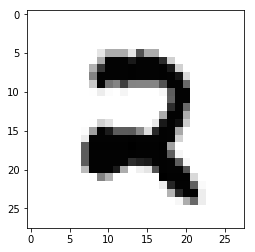

In [19]:
# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y,1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy: ', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1}))

# Get one and predict
r = random.randint(0, mnist.test.num_examples - 1)
print("Label:      ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1], keep_prob: 1}))

plt.imshow(mnist.test.images[r:r + 1].reshape(28,28), cmap='Greys', interpolation='nearest')
plt.show()